<a href="https://colab.research.google.com/github/MatveiV/ML_Fin_Notebooks/blob/main/250120_pytorch_tsmixer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%%capture
!pip install pytorch-tsmixer
!pip install yfinance tqdm
!pip install requests backtrader[plotting] gdown -q

In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchtsmixer import TSMixer
import matplotlib.pyplot as plt
from tqdm import tqdm



In [ ]:
tickers = ['SBER.ME']
start = '2022-01-01'
end = '2023-01-01'
df_ticker_return = pd.DataFrame()
for ticker in tickers:
    ticker_yf = yf.Ticker(ticker)
    if df_ticker_return.empty:
        df_ticker_return = ticker_yf.history(start = start, end = end)
        df_ticker_return['ticker']= ticker
    else:
        data_temp = ticker_yf.history(start = start, end = end)
        data_temp['ticker']= ticker
        df_ticker_return = df_ticker_return.append(data_temp)
df_ticker_return=df_ticker_return.drop(columns=['Dividends','Stock Splits','ticker'])
df_ticker_return.to_csv("/content/data22-23.csv")
df_ticker_return.head(2)

,Open,High,Low,Close,Volume
Date,,,,,
2022-01-03 00:00:00+03:00,296.100006,303.880005,296.000000,302.850006,45109764
2022-01-04 00:00:00+03:00,308.529999,308.799988,301.630005,304.500000,49869680


100%|██████████| 100000/100000 [54:01<00:00, 30.85it/s]


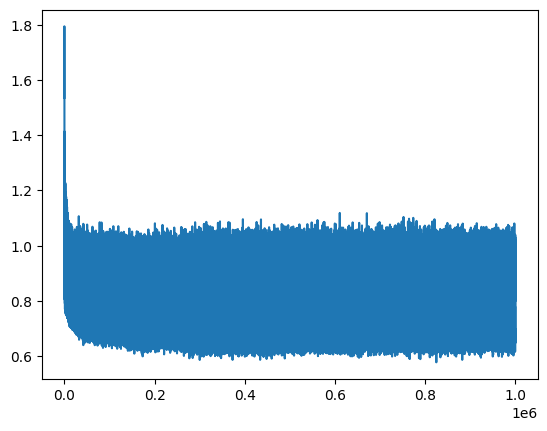

In [ ]:
# Model parameters
sequence_length = 10
prediction_length = 5
input_channels = 1
output_channels = 1

model = TSMixer(sequence_length, prediction_length, input_channels, output_channels)# Create the TSMixer model
criterion = nn.MSELoss()# Loss function and optimizer
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Dummy dataset (replace with real data)
# Assuming batch_size, seq_len, num_features format
X_train = torch.randn(10,32, sequence_length, input_channels)
y_train = torch.randn(10,32, prediction_length, output_channels)

# Training loop
arr_loss=[]
num_epochs = 100000
for epoch in tqdm(range(num_epochs)):
    model.train()
    for X,y in zip(X_train, y_train):
        optimizer.zero_grad()# Zero the parameter gradients
        outputs = model(X)# Forward pass
        loss = criterion(outputs, y);arr_loss.append(loss.item())
        loss.backward()# Backward pass and optimize
        optimizer.step()

plt.plot(arr_loss)
plt.show()


In [ ]:
X_test = torch.randn(10,10, 1)
outputs = model(X_test)
outputs[:1]

tensor([[[-0.5909],
         [-0.2099],
         [ 0.2699],
         [ 0.1323],
         [ 0.5019]]], grad_fn=<SliceBackward0>)

**Вопрос 1** Метод из примера TSMixer с лекции обрезает последний sequenсe, так как не хватает (и не может по определению хватать) данных в исходном датасете

**Ответ 1**  Можно использовать скользящее окно, которое будет сдвигаться по датасету, создавая перекрывающиеся последовательности, что позволит использовать все данные в датасете и сделать количество предсказаний равным количеству баров.

**Вопрос 2** - в целом повторюсь (писал уже ранее) в рамках курса не хватило лекций про подходы формирования стратегий (именно в терминах библиотеки backtesting)

**Ответ 2**  Можно использовать торговую платформу [Backtrader](https://www.backtrader.com/docu/cerebro/)



In [ ]:
import datetime

import backtrader as bt
import backtrader.analyzers as btanalyzers
import backtrader.feeds as btfeeds
import backtrader.strategies as btstrats

cerebro = bt.Cerebro()

# data
dataname =  "/content/data22-23.csv"
data = btfeeds.BacktraderCSVData(dataname=dataname, timeframe=bt.TimeFrame.Days)


cerebro.adddata(data)
#----------------------------------------------------------------Ответ на вопрос---------------------------------------------------
# 1.Стратегия
cerebro.addstrategy(btstrats.SMA_CrossOver)

# 2.Анализаторы
cerebro.addanalyzer(btanalyzers.SharpeRatio, _name='mysharpe')
#----------------------------------------------------------------Ответ на вопрос---------------------------------------------------
# Add the Data Feed to Cerebro
cerebro.adddata(data)

# Set our desired cash start
cerebro.broker.setcash(100000.0)

# Print out the starting conditions
print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

try:
  thestrats = cerebro.run()
except:...
#thestrat = thestrats[0]
# Print out the final result
print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())


Starting Portfolio Value: 100000.00
Final Portfolio Value: 100000.00


**Вопрос 3** - нужно ли делать shuffle для данных для обучения НС, например TSMixer

**Ответ 3** Временные ряды нельзя перемешивать, поскольку в них содержится повторяющаяся сезонность и остаточный шум

In [ ]:
!pip install matplotlib pandas numpy statsmodels -qq
import statsmodels.api as sm

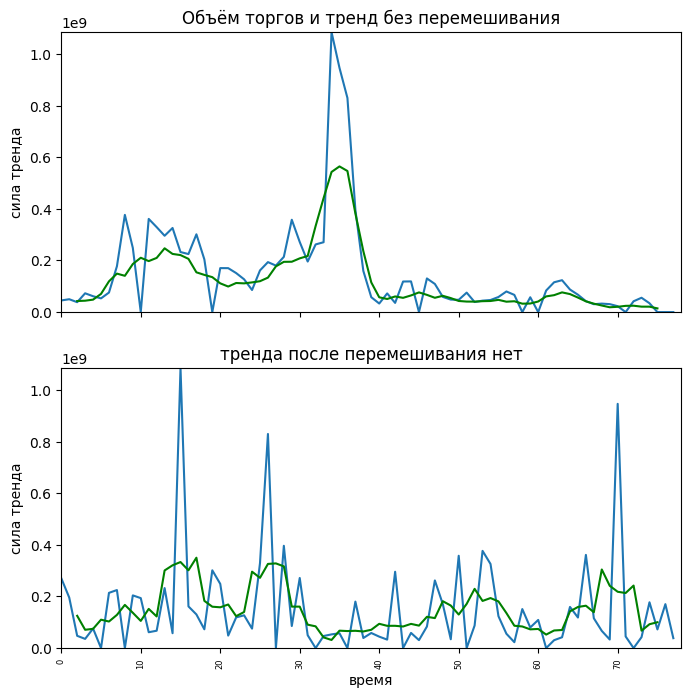

In [ ]:
y = df_ticker_return["Volume"]
x = range(y.shape[0])
trend = sm.tsa.seasonal_decompose(y,period=5).trend
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
ax1.set(xlim=(0, y.shape[0]), ylim=(0, y.max()))
ax2.set(xlim=(0, y.shape[0]), ylim=(0, y.max()))

ax1.plot(x, y)
ax1.set_title('Объём торгов и тренд без перемешивания')
ax1.tick_params(axis='x', labelrotation=90, labelsize=6)
ax2.set_title('тренда после перемешивания нет')
ax2.set_xlabel('время')
ax1.set_ylabel('сила тренда')
ax2.set_ylabel('сила тренда')
ax1.plot(x,trend*0.8,color='green')
y = df_ticker_return.sample(frac=1)["Volume"]
x = range(y.shape[0])
trend = sm.tsa.seasonal_decompose(y,period=5).trend
ax2.plot(x, y)
ax2.plot(x,trend,color='green')
ax2.tick_params(axis='x', labelrotation=90, labelsize=6)
f.set_figheight(8)
f.set_figwidth(8)
plt.show()

**Вопрос 4** - можно ли обучить нейронную сеть не только на данных о дате закрытия, но и на других фичах (аналогично классическому ML)? Как это сделать?

**Ответ 4** Используя [Мультиклассовый классификатор](https://scikit-learn.ru/stable/modules/multiclass.html)

**Вопрос 5** - в рамках создания ансамбля и стратегии возникает проблема с мержем значений (мержем датафрейма для бэктестинга и результатов предсказаний нейронных сетей). Проблема в том, что в данных для обучения нейронных сетей нет дат - и на какой день предсказание - не совсем очевидно + итовый размер выхода нерйонной сети может отличаться от размера тестовой выборки (см вопрос 1)

Вопрос - нужно ли (и можно ли) в числе фич для обучения модели (нейронных сетей) оставлять дату?

Разнообразные трансформации могут приводить к удалению NaN значений (например при ТА анализе) и в итоге набор данных для
обучения отличается от набора данных для бэктестинга

**Ответ 5** набор данных для обучения всегда отличается от набора данных для бэктестинга

**Вопрос 6** - как понять что модель обучилась достаточно хорошо? Речь уже про классический ML. Какой accuracy считать приемлемым? Какой f1 считать приемлемым?

**Ответ 6** между Dummy и SOTA в зависимости от задачи

**Вопрос 7** - Что такое thresholds (cutoff) в понятиях метрик качества? Почему он возникает и зачем нужен?

**Ответ 7** Пороговые значения позволяют преобразовать **непрерывный** выход модели (например, вероятность) в **дискретный** результат (например, положительный или отрицательный класс).


**Вопрос 8** - можно ли вообще в контексте бэктестинга говорить о необходимости разделения данных на train и test? обучения же по факту никакого не происходит?

**Ответ 8** Если используется только технический анализ, то  разделение данных на train и test не требуется.

**Вопрос 9** - связан с вопросом 2 и 8 - На каком объеме данных нужно проводить бэктестинг? Сколько таких данных должно быть? Сотни? Тысячи баров?

**Ответ 9** Нужно использовать затухающие веса, чтобы более ранние данные учитывались с меньшим весом
<img src="https://d7-invdn-com.investing.com/content/picb07ec6ec63c14054dd8ca8597bfac5dc.png" width="50%">

**Вопрос 10** - Как от индикаторов технического анализа переходить к сигналам на покупку или продажу? Какая между ними должна быть взаимосвязь?

**Ответ 10** нет универсальных правил для перехода от индикаторов ТА к сигналам на покупку/продажу. Эффективные взаимосвязи и правила будут варьироваться в зависимости от конкретных торговых стратегий и используемых индикаторов ТА.Чтобы перейти от индикаторов ТА к сигналам на покупку или продажу, необходимо установить четкие правила, определяющие, когда и как использовать индикаторы для генерации торговых сигналов (например, что означаю полосы Боллинджера?)

**Вопрос 11** - методы ансамбля могут давать худший результат чем просто одна модель? Например в бэггинге я получал такую ситуацию
Или это неправильно просто настроено?

**Ответ 11** Зависит от данных и получаемых метрик, обычно на большом наборе данных ансамбли дают результат лучше

**Вопрос 12** - почему на одних и тех же данных при одних и тех же настройках могут абсолютно различаться результаты торговли стратегии на бэктесте?

**Ответ 12** Нужно фиксировать seed для воспроизводимости


**Вопрос 13** - на предыдущем занятии вы говорили про формирование портфеля  Но backteting.py насколько понимаю нацелен только на один инструмент, как тогда применять его на множестве активов?

**Ответ 13** Для работы со множеством активов обучите несколько моделей с  разными алгоритмами и выберите лучшего агента.

**Вопрос 14** 1) По мере прохождения курса я заметил, что хорошие метрики модели порой не гарантируют хорошие метрики на бэктесте. Но, по крайней мере, высокий precision зачастую ведёт к хорошему sharpe ratio. Как правильно и качественно проводить бэктест, чтобы максимизировать вероятность успешности модели/ансамбля на реальных данных?

**Ответ 14** Бэктест должен охватывать достаточно длительный период времени, чтобы захватить различные рыночные условия, включая периоды роста, спада и волатильности. Данные должны быть достаточно вариативными, чтобы отражать широкий спектр возможных будущих рыночных сценариев. Нужно смотреть кривые доходности, графики разницы сделок и другие визуализации, чтобы понять поведение модели.


**Вопрос 15** 2) На курсе зачастую использовались изменения цены через n-ое время для решения задачи классификации (прогноз изменения цены). Допустим я решил построить бота, который торгует одним активом, а бот использует ML модель для классификации роста/падения/флэта цены. Какие способы разметки для данных можно использовать, чтобы ML модель смогла нормально отрабатывать? (например я видел метод тройного барьера, вроде он работает норм у людей, но я пока на этапе проверки)

**Ответ 15** Зависит от конкретной задачи и набора данных:

 Для задач с четко определенными барьерами между классами (например, рост/падение) метод тройного барьера работает хорошо.
 Бинарная классификация подходит для задач, где флэт не является важным классом.
 Многоклассовая классификация позволяет различать более тонкие градации изменения цены.
 Регрессия полезна, когда необходимо прогнозировать точную величину изменения цены.